In [2]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for data preparation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_recall_curve, classification_report, roc_curve, auc

import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf



# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [14]:
# for handling emojis
import demoji
# Handling unicode 
import unicodedata
import tqdm

In [47]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Part 2: NLP Using Deep Learning for Text Classification

## Word Embedding

In [8]:
datapath = '../data/interim/'

In [20]:
train_df = pd.read_csv(datapath + 'interim_train_df.csv')

In [21]:
train_df.head()

,text,Disaster
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [22]:
test_df = pd.read_csv(datapath + 'interim_test_df.csv')
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


## Text Preprocessing

In [23]:
lst_stopwords = stopwords.words("english")

In [26]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=False
                          , lst_stopwords=lst_stopwords):
    ## clean (convert to lowercase. remove punctuations, urls, mentions,  tags, and digits)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r"http\S+", "", text) #remove urls
    text = re.sub('#[^\s]+','', text) #remove hashtags
    text = re.sub('@[^\s]+','', text) #remove tags
    text = re.sub(r'[0-9]+','', text) #remove digits
    text = demoji.replace(text, '') #remove emoijis
    # Return the normal form for the Unicode string
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = text.strip()

            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        whitelist = ["n't", "not", "no"]
        lst_text = [word for word in lst_text if (word not in lst_stopwords or word in whitelist) and len(word) > 1]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text


In [27]:
train_df['text'] = train_df['text'].apply(utils_preprocess_text)

In [28]:
(train_df.text == "" ).sum() # check for empty tweets after preprocessing

0

In [29]:
test_df["text"] = test_df["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
test_df.head()

,text
0,happened terrible car crash
1,heard earthquake different city stay safe ever...
2,forest fire spot pond goose fleeing across str...
3,apocalypse lighting spokane wildfire
4,typhoon soudelor kill china taiwan


## Split the data into training and testing sets

In [30]:

X_train, X_test, y_train, y_test = train_test_split(train_df.text, train_df.Disaster, test_size=0.1, random_state=42, stratify=train_df.Disaster)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 6851
# Test data samples: 762


In [58]:
X_train

3920    please dont flood poor robertbenglunds mention...
2345    general news uaedemolition house waterway begi...
4612           adamrubinespn familia arm injury head case
1826    intactmhpartliftsoddsplaneglidednotcrashedinto...
4032               fire pisgah national forest grows acre
                              ...                        
2819          dead injured displaced syria visit u canada
1891                                man crushed death car
6447    haji_hunter middleeasteye maybe muzzies sponta...
1337    man run burning building living scared hit gir...
3518    liked youtube video mini pony pack punch live ...
Name: text, Length: 6851, dtype: object

### The number of words and sequence length in the training corpus
This will be used for the neural network model in Keras.

In [59]:
word_counts = X_train.str.split(expand=True).stack().value_counts().reset_index()
word_counts.columns = ['word', 'count']

In [60]:
word_counts.head()

,word,count
0,like,310
1,fire,309
2,not,274
3,amp,270
4,im,260


In [61]:
print('The number of words in the training corpus is: ', word_counts.shape[0])

The number of words in the training corpus is:  14840


In [62]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    6851.000000
mean        9.192527
std         3.518192
min         1.000000
25%         7.000000
50%         9.000000
75%        12.000000
max        23.000000
Name: text, dtype: float64

# Train a Deep Learning Model

In [63]:
# Source: https://github.com/bertcarremans/TwitterUSAirlineSentiment/blob/master/source/Using%20Word%20Embeddings%20for%20Sentiment%20Analysis.ipynb

In [64]:
NB_WORDS = 14774  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 23  # Maximum number of words in a sequence
#GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings

In [65]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train the model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='adam'
                  , loss='binary_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

In [66]:
# Source: https://github.com/DTrimarchi10/confusion_matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['not_deisaster', 'disaster']

def model_peformance(y_test, predicted_prob,
                          group_names=labels,
                          categories=categories,
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title='Confusion Matrix'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''
    
    predicted = (predicted_prob >= 0.5).astype('int32')
    
    cf = confusion_matrix(y_test, predicted)
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # MAKE THE HEATMAP VISUALIZATION
#     plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories, ax = ax[0])

    if xyplotlabels:
        ax[0].set_ylabel('True label')
        ax[0].set_xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        ax[0].set_title(title)
        
# Plot ROC Curve    
    auc = roc_auc_score(y_test, predicted_prob)
#     print('Area Under the Receiver Operating Characteristic Curve = ', auc)
    fpr, tpr, _ =  roc_curve(y_test, predicted_prob)

    ax[1].plot(fpr, tpr, marker='.', label='(AUROC = %0.3f)' % auc)

    # Title
    ax[1].set_title('ROC Plot')
    # Axis labels
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    fig.suptitle('Model Performance on the Test Dataset')
    
    plt.show()
    print('\nDetails:')
    print(classification_report(y_test, predicted))



### Words Tokenization

In [67]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ",
               oov_token='<UNK>')
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 6851 documents
14774 words in dictionary
Top 5 most common words are: [('like', 310), ('fire', 309), ('not', 274), ('amp', 270), ('im', 261)]


In [68]:
X_train_seq[3]

[5590, 11, 5591, 821]

### Let's check what is the 'amp' token

In [69]:
train_df[train_df.text.str.contains(' amp ')].head()

,text,Disaster
62,rene ablaze amp jacinta secret fallen sky edit...,0
64,nowplaying rene ablaze amp ian buff magnitude edm,0
67,cant kid cuz got bicycle accident amp split te...,0
70,personalinjury accident summer read advice amp...,0
171,early wake call sister begging come amp ride w...,1


In [70]:
# Check the original tweet
df = pd.read_csv(datapath + 'interim_train_df.csv')

In [71]:
df.iloc[171].to_list()

['Early wake up call from my sister begging me to come over &amp; ride w/her in the ambulance to the hospital #RODKiai',
 1]

- 'amp' is the preprocessed form of '&amp:' which is &

## Adjust the word sequences to an equal length

In [72]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [73]:
X_train_seq_trunc[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  211,   57,   16, 5608,  328,  277, 5609,  918,
        104], dtype=int32)

In [74]:
print('The lenght of word sequences is adjusted to be = ', len(X_train_seq_trunc[10]))

The lenght of word sequences is adjusted to be =  23


### Prepare a Validation set 

In [75]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train, test_size=0.1, random_state=42, stratify=y_train)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:', X_valid_emb.shape)

Shape of validation set: (686, 23)


## Experiment -1: Build a simple Neural Network based on the Generated Word Embedding

In [76]:
# one node in the output
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(1, activation='sigmoid'))
emb_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 8)             118192    
_________________________________________________________________
flatten_1 (Flatten)          (None, 184)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 185       
Total params: 118,377
Trainable params: 118,377
Non-trainable params: 0
_________________________________________________________________


In [77]:
X_train_emb.shape, y_train_emb.shape

((6165, 23), (6165,))

In [78]:
X_valid_emb.shape, y_valid_emb.shape

((686, 23), (686,))

In [79]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

In [80]:
emb_history.history['accuracy'][-1]

0.8176804780960083

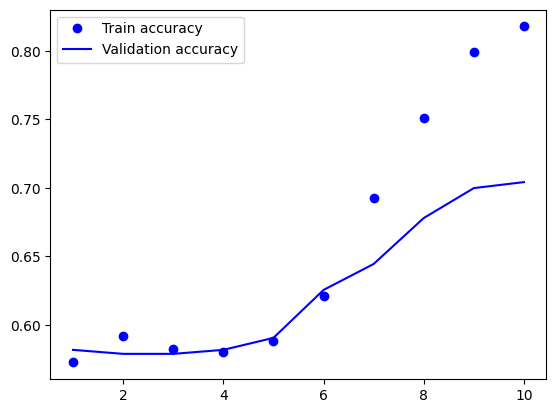

In [81]:
eval_metric(emb_history, 'accuracy')


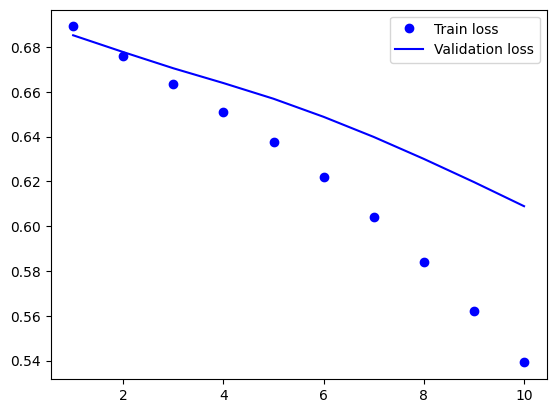

In [82]:
eval_metric(emb_history, 'loss')

In [83]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train, X_test_seq_trunc, y_test, 10)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

24/24 [==============================] - 0s 891us/step - loss: 0.5025 - accuracy: 0.7756
/n
Test accuracy of word embeddings model: 77.56%


### The model seems to be improved by increasing the number of epochs

### Re-fit the using Early Stop

In [86]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
emb_model.fit(X_train_emb, y_train_emb,
          validation_data=(X_valid_emb, y_valid_emb),
          epochs=50, 
          batch_size=BATCH_SIZE,
          callbacks=[es], 
          verbose=1)

Epoch 1/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2795 - accuracy: 0.9450 - val_loss: 0.3260 - val_accuracy: 0.9257
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 0.2637 - accuracy: 0.9468 - val_loss: 0.3180 - val_accuracy: 0.9257
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.2489 - accuracy: 0.9491 - val_loss: 0.3117 - val_accuracy: 0.9257
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 0.2356 - accuracy: 0.9556 - val_loss: 0.3066 - val_accuracy: 0.9257
Epoch 5/50
13/13 [==============================] - 0s 6ms/step - loss: 0.2231 - accuracy: 0.9585 - val_loss: 0.3019 - val_accuracy: 0.9227
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.2114 - accuracy: 0.9588 - val_loss: 0.2981 - val_accuracy: 0.9169
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.2007 - accuracy: 0.9601 - val_loss: 0.2945 - val_accuracy: 0.9169
Epoch 8/50
13/13 [==

### Model Performance

In [87]:
predicted_prob = emb_model.predict(X_test_seq_trunc)
y_pred =(predicted_prob >= 0.5).astype('int32')

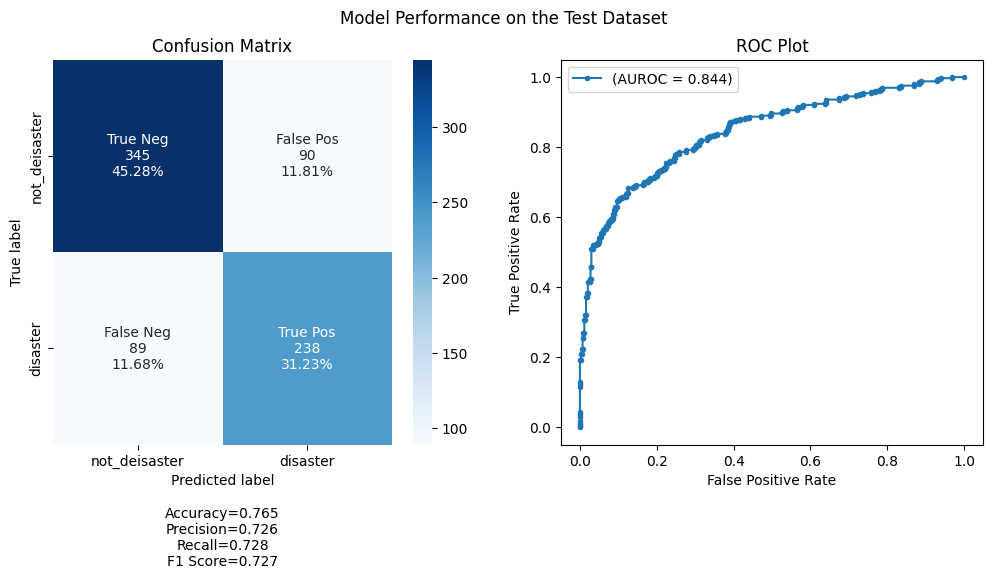


Details:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       435
           1       0.73      0.73      0.73       327

    accuracy                           0.77       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.77      0.77      0.77       762



In [90]:
model_peformance(y_test, predicted_prob)

## Experiment -2: Adding layer and increasing the output dimension of the embedding layer to 32

In [91]:
# one node in the output
emb_model2 = models.Sequential()
emb_model2.add(layers.Embedding(NB_WORDS, 32, input_length=MAX_LEN))
emb_model2.add(layers.Flatten())
emb_model2.add(layers.Dense(17, activation='relu'))
emb_model2.add(layers.Dense(1, activation='sigmoid'))

emb_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 23, 32)            472768    
_________________________________________________________________
flatten_2 (Flatten)          (None, 736)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 17)                12529     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 18        
Total params: 485,315
Trainable params: 485,315
Non-trainable params: 0
_________________________________________________________________


In [92]:
emb_history2 = deep_model(emb_model2, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

In [93]:
emb_history2.history['accuracy'][-1]

0.974047064781189

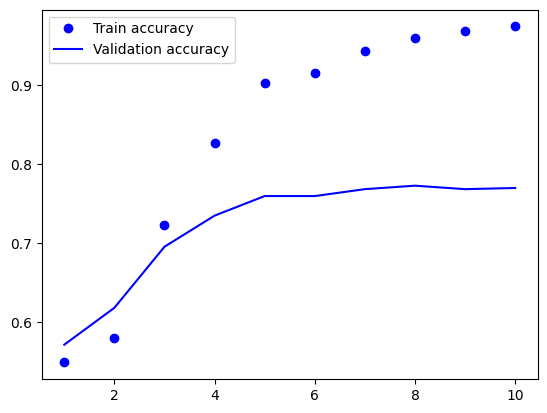

In [94]:
eval_metric(emb_history2, 'accuracy')


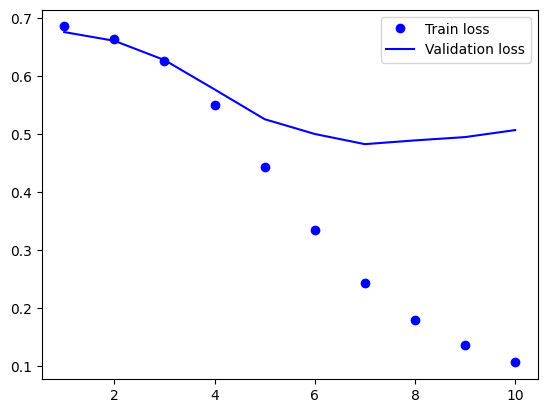

In [95]:
eval_metric(emb_history2, 'loss')

In [96]:
emb_results = test_model(emb_model2, X_train_seq_trunc, y_train, X_test_seq_trunc, y_test, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

24/24 [==============================] - 0s 996us/step - loss: 0.5752 - accuracy: 0.7572
/n
Test accuracy of word embeddings model: 75.72%


In [100]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
emb_model2.fit(X_train_emb, y_train_emb,
          validation_data=(X_valid_emb, y_valid_emb),
          epochs=50, 
          batch_size=BATCH_SIZE,
          callbacks=[es], 
          verbose=1)

Epoch 1/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0395 - accuracy: 0.9872 - val_loss: 0.0620 - val_accuracy: 0.9796
Epoch 2/50
13/13 [==============================] - 0s 12ms/step - loss: 0.0366 - accuracy: 0.9872 - val_loss: 0.0635 - val_accuracy: 0.9796
Epoch 3/50
13/13 [==============================] - 0s 11ms/step - loss: 0.0346 - accuracy: 0.9880 - val_loss: 0.0667 - val_accuracy: 0.9796
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


In [101]:
predicted_prob = emb_model2.predict(X_test_seq_trunc)
y_pred =(predicted_prob >= 0.5).astype('int32')

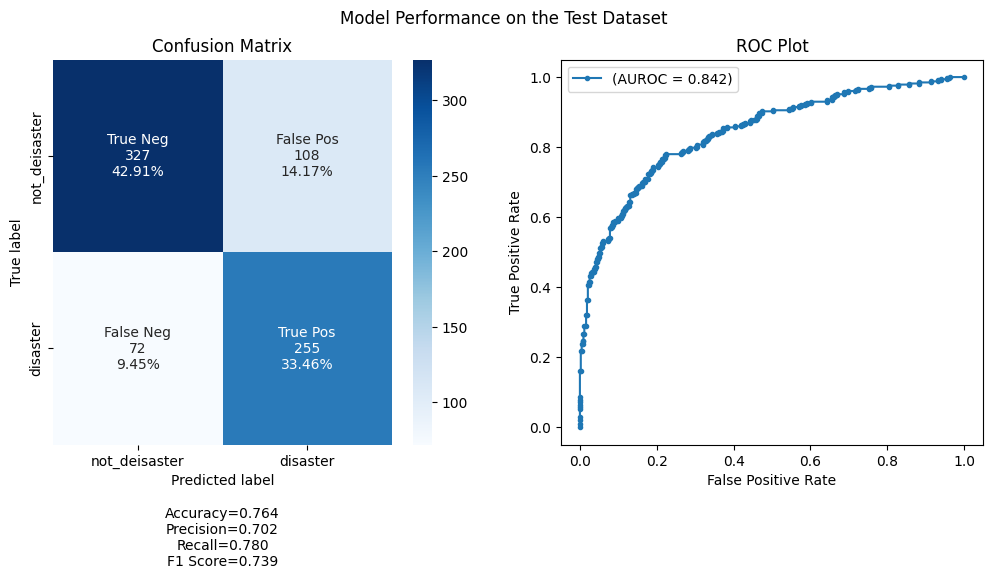


Details:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       435
           1       0.70      0.78      0.74       327

    accuracy                           0.76       762
   macro avg       0.76      0.77      0.76       762
weighted avg       0.77      0.76      0.76       762



In [102]:
model_peformance(y_test, predicted_prob)

- ### There is no improvement over the first (simpler) model

## Experiment -3: Using Recurrent Neural Network with LSTM with Dropout

In [103]:
# one node in the output
emb_model3 = models.Sequential()
emb_model3.add(layers.Embedding(NB_WORDS, 32, input_length=MAX_LEN))
emb_model3.add(layers.LSTM(60, dropout=0.5))
emb_model3.add(layers.Dense(1, activation='sigmoid'))

emb_model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 23, 32)            472768    
_________________________________________________________________
lstm (LSTM)                  (None, 60)                22320     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61        
Total params: 495,149
Trainable params: 495,149
Non-trainable params: 0
_________________________________________________________________


In [104]:
emb_history3 = deep_model(emb_model3, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

In [105]:
emb_history3.history['accuracy'][-1]

0.9385239481925964

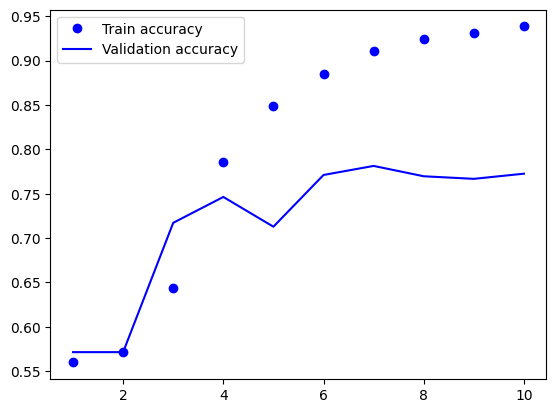

In [106]:
eval_metric(emb_history3, 'accuracy')


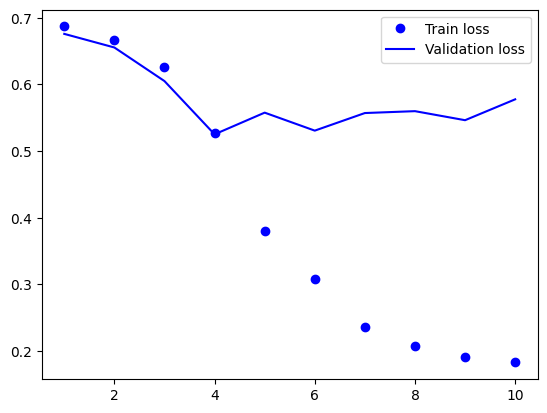

In [107]:
eval_metric(emb_history3, 'loss')

In [108]:
emb_results = test_model(emb_model3, X_train_seq_trunc, y_train, X_test_seq_trunc, y_test, 5)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

24/24 [==============================] - 0s 4ms/step - loss: 0.6775 - accuracy: 0.7940
/n
Test accuracy of word embeddings model: 79.40%


In [109]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
emb_model3.fit(X_train_emb, y_train_emb,
          validation_data=(X_valid_emb, y_valid_emb),
          epochs=50, 
          batch_size=BATCH_SIZE,
          callbacks=[es], 
          verbose=1)

Epoch 1/50
13/13 [==============================] - 1s 88ms/step - loss: 0.0744 - accuracy: 0.9731 - val_loss: 0.1700 - val_accuracy: 0.9431
Epoch 2/50
13/13 [==============================] - 1s 75ms/step - loss: 0.0710 - accuracy: 0.9747 - val_loss: 0.1738 - val_accuracy: 0.9373
Epoch 3/50
13/13 [==============================] - 1s 66ms/step - loss: 0.0684 - accuracy: 0.9765 - val_loss: 0.2442 - val_accuracy: 0.9169
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


In [110]:
predicted_prob = emb_model3.predict(X_test_seq_trunc)
y_pred =(predicted_prob >= 0.5).astype('int32')

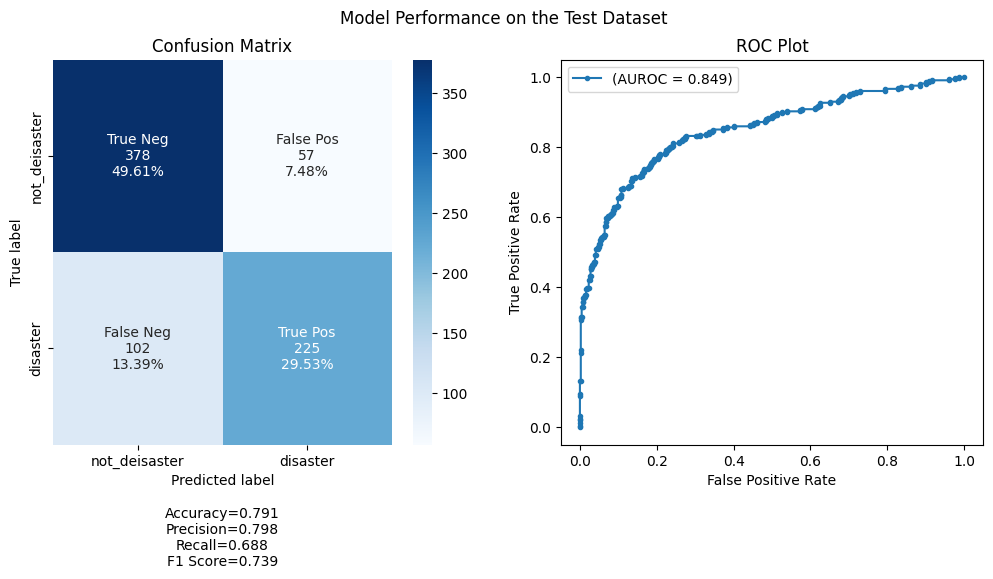


Details:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       435
           1       0.80      0.69      0.74       327

    accuracy                           0.79       762
   macro avg       0.79      0.78      0.78       762
weighted avg       0.79      0.79      0.79       762



In [111]:
model_peformance(y_test, predicted_prob)

- ### We achieved a better accuracy of 0.791 using the LSTM 

## Experiment -4: CNN Models

In [124]:
model = Sequential()
model.add(Embedding(NB_WORDS, 32, input_length=MAX_LEN))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(layers.Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=8, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 23, 32)            472768    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 23, 64)            8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 64)            0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 11, 32)            8224      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 5, 32)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 5, 8)             

In [125]:
emb_history4 = deep_model(model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

In [126]:
emb_history4.history['accuracy'][-1]

0.980697512626648

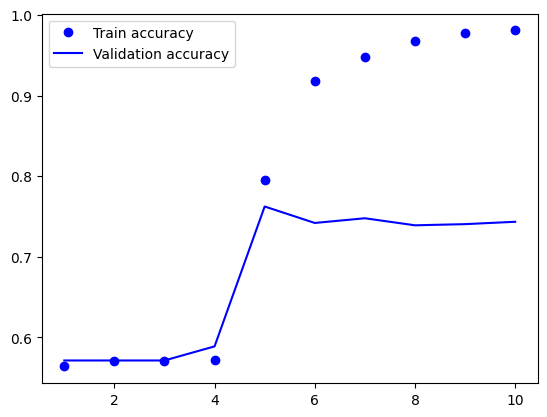

In [127]:
eval_metric(emb_history4, 'accuracy')


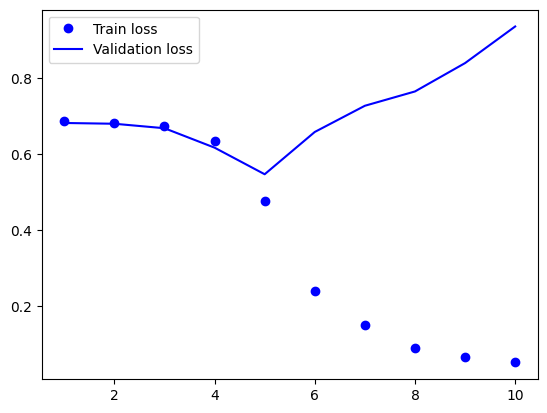

In [128]:
eval_metric(emb_history4, 'loss')

In [129]:
emb_results = test_model(model, X_train_seq_trunc, y_train, X_test_seq_trunc, y_test, 4)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

24/24 [==============================] - 0s 2ms/step - loss: 0.8032 - accuracy: 0.7546
/n
Test accuracy of word embeddings model: 75.46%


In [130]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
model.fit(X_train_emb, y_train_emb,
          validation_data=(X_valid_emb, y_valid_emb),
          epochs=50, 
          batch_size=BATCH_SIZE,
          callbacks=[es], 
          verbose=1)

Epoch 1/50
13/13 [==============================] - 1s 44ms/step - loss: 0.0379 - accuracy: 0.9870 - val_loss: 0.0668 - val_accuracy: 0.9810
Epoch 2/50
13/13 [==============================] - 0s 38ms/step - loss: 0.0356 - accuracy: 0.9870 - val_loss: 0.0843 - val_accuracy: 0.9708
Epoch 3/50
13/13 [==============================] - 1s 41ms/step - loss: 0.0437 - accuracy: 0.9849 - val_loss: 0.0962 - val_accuracy: 0.9738
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


In [131]:
predicted_prob = model.predict(X_test_seq_trunc)
y_pred =(predicted_prob >= 0.5).astype('int32')

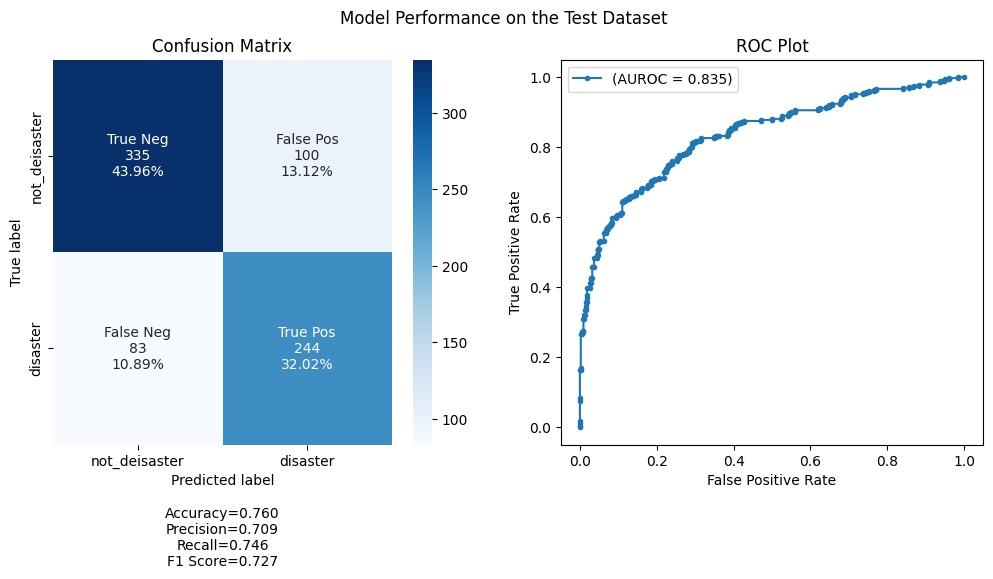


Details:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       435
           1       0.71      0.75      0.73       327

    accuracy                           0.76       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.76      0.76      0.76       762



In [132]:
model_peformance(y_test, predicted_prob)

- ### There is no improvement over LSTM 

## Experiment -5: Using Pre-trained Model (transfer learning)